In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.nn.functional import pad
import seaborn as sns
import warnings
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:1")
else:
    DEVICE = torch.device("cpu")

In [2]:
class DualLSTM(nn.Module):
    
    def __init__(self, 
                        temporal_input_size,
                        temporal_hidden_size,
                        temporal_num_layers,
                        spatial_input_size,
                        spatial_hidden_size,
                        spatial_num_layers,
                        target_year_input_size,
                        output_size,
                ):
        
        super(DualLSTM, self).__init__()
    
        self.spatial_lstm = nn.GRU(
            spatial_input_size,
            spatial_hidden_size,
            spatial_num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0
        )
        
        self.temporal_lstm = nn.GRU(
            temporal_input_size,
            temporal_hidden_size,
            temporal_num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0
        )
        
        self.dense_layer = nn.Sequential(
            nn.Linear(temporal_hidden_size // 1 + target_year_input_size, temporal_hidden_size // 8),
            nn.PReLU(),
            nn.Linear(temporal_hidden_size // 8, output_size),
        )
        
        self.self_fc = nn.Sequential(
                                    nn.Linear(spatial_input_size, spatial_hidden_size),
                                    nn.PReLU()
        )
        
        self.spatial_lstm_layer_norm = nn.LayerNorm(spatial_input_size)
        self.temporal_lstm_layer_norm = nn.LayerNorm(temporal_input_size)
        
        
    def forward(self, x, x_target):

        # 1 X T X N X F
        
        time_data = unpack_sequence(x)
        temporal_lstm_input = []
        
        for data in time_data:
            
            self_output_feature = self.self_fc(data[0])
            
            if data.shape[0] > 1:
                
                neighbours_features = data[1:, :]
                spacial_lstm_output = self.spatial_lstm(self.spatial_lstm_layer_norm(neighbours_features))[0][-1, :]   
                temporal_lstm_input.append(spacial_lstm_output + self_output_feature)
            else:
                temporal_lstm_input.append(self_output_feature)
        
        temporal_lstm_input = torch.stack(temporal_lstm_input, dim=0)
        temporal_features = self.temporal_lstm(self.temporal_lstm_layer_norm(temporal_lstm_input))[0][-1, :]
        temporal_features = torch.cat([temporal_features, x_target], dim=-1)[None, ...]        
        out = self.dense_layer(temporal_features)

        return out

In [17]:
class PartialInferenceNNeighbors:
    def __init__(
        self,
        data_root_dir,
    ):
        data_root_dir = Path(data_root_dir)

        if not data_root_dir.is_dir():
            raise ValueError(
                f"The directory {data_root_dir.as_posix()} does not exist."
            )

        self.data_root_dir = data_root_dir

        # read the data
        data_path = data_root_dir / "data.pkl"

        if not data_path.is_file():
            raise ValueError(f"The file {data_path.as_posix()} does not exist.")

        self.data = pd.read_pickle(data_path)

        # load model
        self.nn = DualLSTM(
                    spatial_input_size=79,
                    spatial_hidden_size=128,
                    spatial_num_layers=2,
                    temporal_input_size=128,
                    temporal_hidden_size=256,
                    temporal_num_layers=2,
                    target_year_input_size=10,
                    output_size=1
                    ).to(device=DEVICE).eval()
        
        self.nn.load_state_dict(torch.load("../final_data/dual_lstm.pt"))

        # preprocess the data
        self.__preprocess_data()

        # load distance data
        self.__load_distance_data()

    def __load_distance_data(self):
        self.distance_2018 = pd.read_csv(
            self.data_root_dir / "distances_2018.csv"
        ).set_index("Qid_1")
        self.distance_2019 = pd.read_csv(
            self.data_root_dir / "distances_2019.csv"
        ).set_index("Qid_1")
        self.distance_2020 = pd.read_csv(
            self.data_root_dir / "distances_2020.csv"
        ).set_index("Qid_1")
        self.distance_2021 = pd.read_csv(
            self.data_root_dir / "distances_2021.csv"
        ).set_index("Qid_1")
        self.distance_2022 = pd.read_csv(
            self.data_root_dir / "distances_2022.csv"
        ).set_index("Qid_1")

    def __normalize_columns(self):
        
        #double root scale
        self.cleaned_data.PPSVACWert = self.cleaned_data.PPSVACWert.clip(lower=0, upper=None)
        self.cleaned_data.PPSVACWert = self.cleaned_data.PPSVACWert ** 0.25
        
        self.cleaned_data.Preis = (
            self.cleaned_data.Preis - self.cleaned_data.Preis.mean()
        ) / self.cleaned_data.Preis.std()
        self.cleaned_data.Laenge = (
            self.cleaned_data.Laenge - self.cleaned_data.Laenge.mean()
        ) / self.cleaned_data.Laenge.std()
        self.cleaned_data.Breite = (
            self.cleaned_data.Breite - self.cleaned_data.Breite.mean()
        ) / self.cleaned_data.Breite.std()
        self.cleaned_data.PPSVACWert = (
            self.cleaned_data.PPSVACWert - self.cleaned_data.PPSVACWert.mean()
        ) / self.cleaned_data.PPSVACWert.std()

        list_of_t = [f"TD{i:02d}" for i in range(1, 35)]

        for i in list_of_t:
            self.cleaned_data[i] = (
                self.cleaned_data[i] - self.cleaned_data[i].mean()
            ) / self.cleaned_data[i].std()
        
        GJ_min = self.cleaned_data.GJ.min()
        GJ_max = self.cleaned_data.GJ.max()
        
        self.cleaned_data.GJ = (self.cleaned_data.GJ - GJ_min) / (GJ_max - GJ_min)

    def __separate_data(self):
        self.data_2018 = (
            self.cleaned_data[self.cleaned_data.GJ == (2018 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )
        self.data_2019 = (
            self.cleaned_data[self.cleaned_data.GJ == (2019 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )
        self.data_2020 = (
            self.cleaned_data[self.cleaned_data.GJ == (2020 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )
        self.data_2021 = (
            self.cleaned_data[self.cleaned_data.GJ == (2021 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )
        self.data_2022 = (
            self.cleaned_data[self.cleaned_data.GJ == (2022 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )
        self.data_2023 = (
            self.cleaned_data[self.cleaned_data.GJ == (2023 - 2018) / (2023 - 2018)]
            .drop(columns=["Qid"])
            .copy()
        )

    def __preprocess_data(self):
        CONST_COLUMNS = [
            "Stellensubart_1",
            "Stellensubart_2",
            "Stellensubart_3",
            "Stellensubart_4",
            *[f"T{i}" for i in range(1, 35)],
            *[f"TD{i:02d}" for i in range(1, 35)],
            "Preis",
            "Beleuchtet",
            "Laenge",
            "Breite",
            "Eigenfläche",
            "PPSVACWert",
            "Qid",
            "GJ",
        ]

        # set Qid column as index and take the required columns
        cleaned_data = self.data.set_index("Qid", drop=False)
        cleaned_data.Qid = cleaned_data.Qid.astype(int)
        self.cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

        # normalize the data
        self.__normalize_columns()

        # separate the data into years
        self.__separate_data()
        
    def __get_constrained_data(self):
           
        columns_to_drop = [
            "PPSVACWert",
            *[f"T{i}" for i in range(1, 35)],
            *[f"TD{i:02d}" for i in range(1, 35)],
        ]

        X, x, y, n_neighbors = [], [], [], []

        all_year_data = [
            self.data_2018,
            self.data_2019,
            self.data_2020,
            self.data_2021,
            self.data_2022,
        ]

        all_year_distances = [
            self.distance_2018,
            self.distance_2019,
            self.distance_2020,
            self.distance_2021,
            self.distance_2022,
        ]
        
        unique_qids = self.cleaned_data.Qid.unique()
        
        for idx, qid in enumerate(tqdm(unique_qids)):
            
            if (self.data_2023.index == qid).sum():

                neighbours_features = []

                max_neighbors = 0
                for year_data, year_distances in zip(all_year_data, all_year_distances):
                    
                    current_distances = year_distances[year_distances.index == qid]
                    
                    
                    if (current_distances.shape[0] == 0) or ((year_data.index == qid).sum() == 0):
                        continue
                    
                    current_year_neighbours = current_distances[
                        current_distances.Qid_2 != qid
                    ]
                    
                    current_year_neighbours_data = year_data[year_data.index.isin(current_year_neighbours.Qid_2)].values

                    current_year_self_data = year_data[year_data.index == qid].values
                    
                    current_year_data_point = np.concatenate(
                        [current_year_self_data, current_year_neighbours_data],
                        axis=0,
                    )
                    
                    current_year_data_point = torch.from_numpy(current_year_data_point)
                    
                    neighbours_features.append(current_year_data_point)
                    
                    current_year_neighbors = current_distances.shape[0] - 1
                    max_neighbors = current_year_neighbors if current_year_neighbors > max_neighbors else max_neighbors
                
                if len(neighbours_features) == 0:
                    continue
                
                
                # In this case we take max number of neighbours over all years
                n_neighbors.append(max_neighbors)
                    
                neighbours_features = pack_sequence(neighbours_features, enforce_sorted=False)
                
                self_data_2023 = self.data_2023[self.data_2023.index == qid].drop(columns=columns_to_drop).values
                self_data_2023 = torch.from_numpy(self_data_2023)

                label = torch.tensor(self.data_2023[self.data_2023.index == qid].loc[:, "T1":"T22"].mean().mean())

                X.append(neighbours_features)
                x.append(self_data_2023)
                y.append(label)


        return X, torch.stack(x, dim=0), torch.stack(y, dim=0), torch.tensor(n_neighbors)
    
    def __call__(self):
        
        # get data for qid to pass into nn
        constrained_data = self.__get_constrained_data()
        
        X, x, y_true, n_neighbors = constrained_data
        
        y_pred = []
        
        for X_item, x_item in tqdm(zip(X, x), total=len(X)):
            X_item = X_item.to(dtype=torch.float32, device=DEVICE)
            x_item = x_item[0].to(dtype=torch.float32, device=DEVICE)
            y_pred_item = self.nn(X_item, x_item).item()
            y_pred.append(y_pred_item)
        
        y_pred = torch.tensor(y_pred)
        
        return y_true, y_pred, n_neighbors
        

In [26]:
bins = torch.tensor([0, 5, 10, 50])

In [19]:
predictor = PartialInferenceNNeighbors(data_root_dir="../final_data")

In [20]:
y_true, y_pred, n_neighbors = predictor()

  0%|          | 0/159016 [00:00<?, ?it/s]

  0%|          | 0/131352 [00:00<?, ?it/s]

In [35]:
groups_indices = torch.bucketize(n_neighbors, bins, right=True)

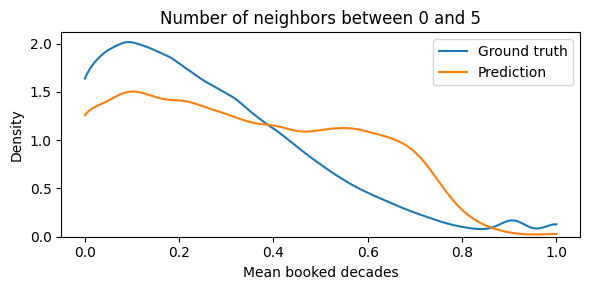

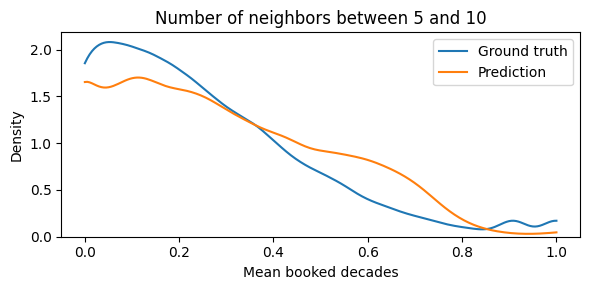

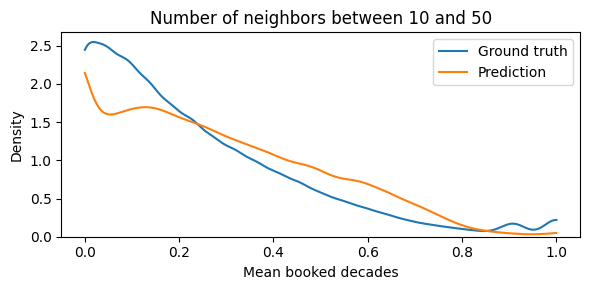

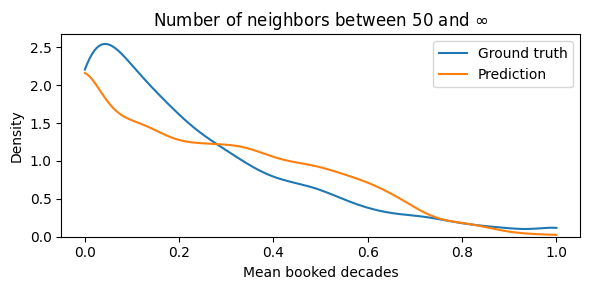

In [53]:
warnings.filterwarnings("ignore")

unique_groups = groups_indices.unique()

for idx, group_num in enumerate(unique_groups):
    
    fig, ax = plt.subplots(figsize=(6, 3))
    
    y_true_group = y_true[groups_indices == group_num]
    y_pred_group = y_pred[groups_indices == group_num]
    
    sns.distplot(y_true_group, kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Ground truth', ax=ax)
    sns.distplot(y_pred_group, kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Prediction', ax=ax)
    ax.set_xlabel("Mean booked decades")
    ax.legend()
    
    left = bins[idx]
    right = r"$\infty$" if idx >= bins.shape[0] - 1 else bins[idx+1]
    
    ax.title.set_text(f"Number of neighbors between {left} and {right}")
    
    fig.tight_layout()